# Data Processing of Real Data

## Create Colormaps

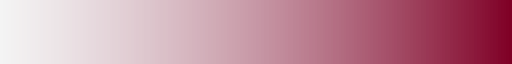

In [37]:
import matplotlib as mpl
import numpy as np

ci = np.array([235,235,235,128])/256
cf = np.array([128,0,38,255])/256

cmap = np.ones((192,4))
for i in range(4):
    cmap[:,i] = np.linspace(ci[i],cf[i],192)

cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
cmap

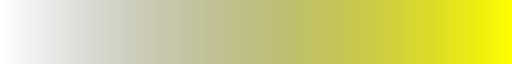

In [38]:
import matplotlib as mpl

cit = np.array([0,0,0,0])/256
cft = np.array([255,255,0,255])/256

cmapt = np.ones((192,4))
for i in range(4):
    cmapt[:,i] = np.linspace(cit[i],cft[i],192)

cmapt = mpl.colors.ListedColormap(cmapt, name='myColorMapt', N=cmapt.shape[0])
cmapt

## Load Bold Data

In [3]:
import nibabel as nib
BOLD = nib.load('Data/RealData/sub-01_task-theoryofmindwithmanualresponse_run-01_bold.nii.gz')
BOLD

In [4]:
BOLD.get_fdata().shape

(72, 72, 36, 179)

## Compute mask and mean image

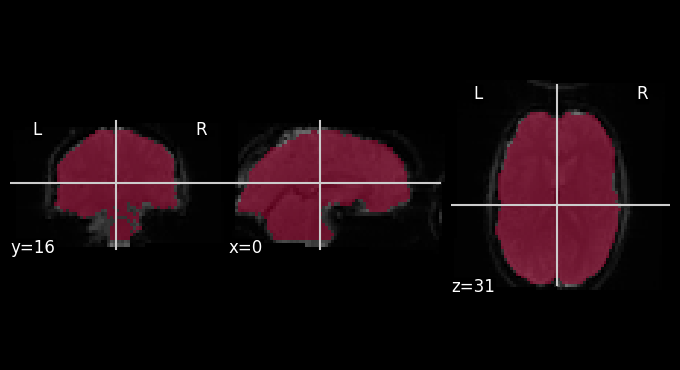

In [5]:
from nilearn.masking import compute_epi_mask
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img
mean_haxby = mean_img(BOLD)
mask_img = compute_epi_mask(BOLD, connected=False)
plot_roi(mask_img,mean_haxby,cmap=cmap)

In [6]:
from nilearn.masking import apply_mask
masked_data = apply_mask(BOLD, mask_img)
masked_data.shape

(179, 40078)

In [5]:
import numpy as np
np.save('Data/RealData/BOLD_Masked.npy',masked_data)

## Load events

In [63]:
import pandas as pd

df_events1 = pd.read_csv('Data/RealData/sub-01_task-theoryofmindwithmanualresponse_run-01_events.tsv',sep='\t')
df_events1

,onset,duration,trial_type,ConditionCode,CorrectAnswerCode,KeyPressed,ResponseTime,StoryCode
0,0.0,2.0,NaN,0.0,0.0,46.0,1.980,0.0
1,2.0,2.0,NaN,0.0,0.0,46.0,1.992,0.0
2,4.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
3,6.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
4,8.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
...,...,...,...,...,...,...,...,...
198,348.0,2.0,NaN,0.0,0.0,46.0,1.985,0.0
199,350.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
200,352.0,2.0,NaN,0.0,0.0,46.0,2.003,0.0
201,354.0,2.0,NaN,0.0,0.0,46.0,1.995,0.0


In [64]:
stim_ev1 = df_events1[df_events1['trial_type'].notnull()]
df_ev1 = df_events1[df_events1['trial_type'].isnull()].reset_index(drop=True)
for r in range(len(stim_ev1)):
  df_ev1.at[int(stim_ev1.iloc[r,0]/2),'duration'] = stim_ev1.iloc[r,:]['duration']
  df_ev1.at[int(stim_ev1.iloc[r,0]/2),'trial_type'] = stim_ev1.iloc[r,:]['trial_type']

df_ev1

,onset,duration,trial_type,ConditionCode,CorrectAnswerCode,KeyPressed,ResponseTime,StoryCode
0,0.0,2.0,NaN,0.0,0.0,46.0,1.980,0.0
1,2.0,2.0,NaN,0.0,0.0,46.0,1.992,0.0
2,4.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
3,6.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
4,8.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
...,...,...,...,...,...,...,...,...
174,348.0,2.0,NaN,0.0,0.0,46.0,1.985,0.0
175,350.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
176,352.0,2.0,NaN,0.0,0.0,46.0,2.003,0.0
177,354.0,2.0,NaN,0.0,0.0,46.0,1.995,0.0


In [65]:
df_ev1['trial_type'].unique()
df_ev1['trial_type'].replace(['false belief question','false belief story','false photo question','false photo story'],['fbq','fbs','fpq','fps'],inplace=True)

/var/folders/t8/1dshmvf55gn478cb8nbc9x880000gn/T/ipykernel_10052/262573010.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ev1['trial_type'].replace(['false belief question','false belief story','false photo question','false photo story'],['fbq','fbs','fpq','fps'],inplace=True)


/opt/homebrew/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

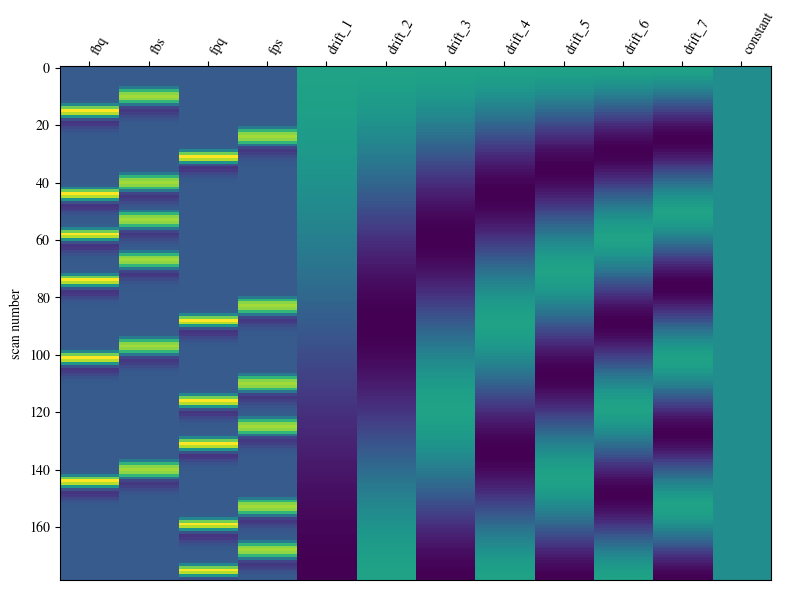

In [67]:
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

tr = 2.0  # repetition time is 2 seconds
n_scans = 179  # the acquisition comprises 179 scans
frame_times = np.arange(n_scans) * tr

conditions = df_ev1['trial_type']
duration = df_ev1['duration']
onsets = df_ev1['onset']

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets, 'duration': duration})

X1 = make_first_level_design_matrix(frame_times, events)

fig, ax = plt.subplots(figsize=(8, 6))
plot_design_matrix(X1, ax=ax)

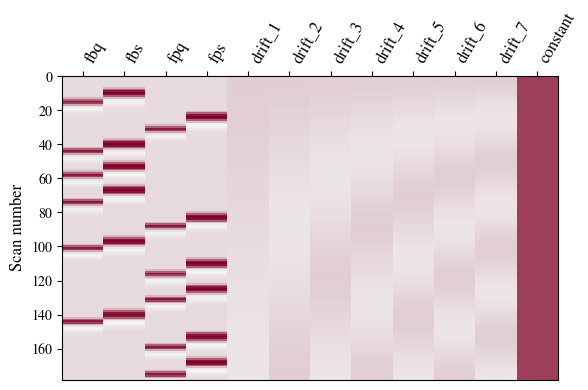

In [75]:
from nilearn.glm.first_level import check_design_matrix
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fig, ax = plt.subplots(figsize=(6, 4))
_,X,names = check_design_matrix(X1)
ax.imshow(X, interpolation="nearest", aspect="auto",cmap=cmap)
ax.set_ylabel("Scan number",fontsize=12)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=60, ha="left",fontsize=12)
ax.xaxis.tick_top()
plt.tight_layout()
plt.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/dMatEx.png', transparent=True, bbox_inches = 'tight',dpi=1000)

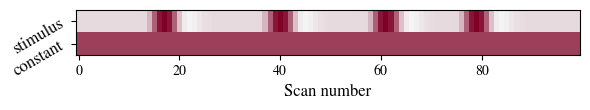

In [83]:
X = pd.read_csv('Data/Simulations/Run032724/2D/X.csv')
fig, ax = plt.subplots(figsize=(6, 1.2))
ax.imshow(X.T, interpolation="nearest", aspect="auto",cmap=cmap)
ax.set_xlabel("Scan number",fontsize=12)
ax.set_yticks([0,1])
ax.set_yticklabels(['stimulus','constant'], rotation=30,fontsize=12)
#ax.xaxis.tick_top()
plt.tight_layout()
plt.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/dMatSimEx.png', transparent=True, bbox_inches = 'tight',dpi=1000)

## Apply Bayesian Model

In [14]:
import bayesianModel as bM
pMap = []
for v in range(len(masked_data[0])):
    print(v)
    BOLDv = masked_data[:,v][np.newaxis].T
    b = bM.betas(X1.values,BOLDv)
    pMap.append(sum(b[:,0]>0)/1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
pMap = np.array(pMap)
pMap

array([0.936, 0.957, 0.993, ..., 0.057, 0.004, 0.242])

In [7]:
import numpy as np
#np.save('Data/RealData/pMap.npy',pMap)
pMap = np.load('Data/RealData/pMap.npy')

In [8]:
from nilearn.masking import unmask
pMap_UM = unmask(pMap,mask_img)
pMap_UM

## Probability maps

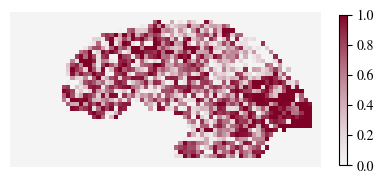

In [42]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.figure(figsize=(5,3))
img = pMap_UM.get_fdata()[36,:,:]
plt.imshow(img.T[::-1,:],cmap=cmap)
plt.colorbar(shrink=0.65)
plt.axis('off')
plt.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/pMapEx.png', transparent=True, bbox_inches = 'tight',dpi=1000)

In [27]:
from nilearn.image import new_img_like
NIFTI = new_img_like(pMap_UM, pMap_UM.get_fdata())

In [9]:
NIFTI

In [10]:
from nilearn.masking import apply_mask
apply_mask(NIFTI,mask_img)

array([0.933, 0.965, 0.99 , ..., 0.059, 0.01 , 0.268])

In [30]:
pMap

array([0.936, 0.957, 0.993, ..., 0.057, 0.004, 0.242])

In [31]:
import th_sm as thSM
Z,N,e,X = thSM.th_sm(pMap,mask_img,-1)

Termination by Jaccard Index in  3  iterations.


In [9]:
import numpy as np
#np.save('Data/RealData/Zeta.npy',Z)
#np.save('Data/RealData/N.npy',N)
#np.save('Data/RealData/eta.npy',e)
#np.save('Data/RealData/X.npy',X)

Z = np.load('Data/RealData/Zeta.npy')
N = np.load('Data/RealData/N.npy')
e = np.load('Data/RealData/eta.npy')
X = np.load('Data/RealData/X.npy')

(-0.5, 35.5, 71.5, -0.5)

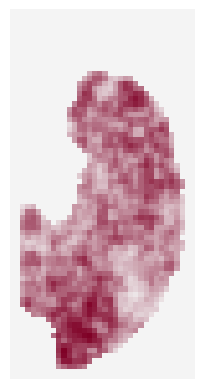

In [20]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

X_UM = unmask(X[1],mask_img)
plt.imshow(X_UM.get_fdata()[36,:,:],cmap=cmap)
plt.axis('off')

(-0.5, 35.5, 71.5, -0.5)

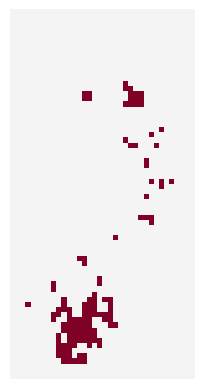

In [13]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

Z_UM = unmask(Z[3],mask_img)
plt.imshow(Z_UM.get_fdata()[36,:,:],cmap=cmap)
plt.axis('off')

## Activation Maps

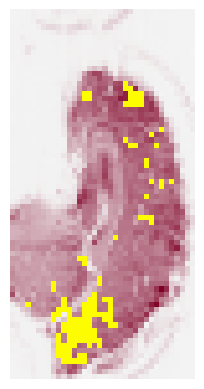

In [19]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

extent = -0.5, 35.5, 71.5, -0.5
fig = plt.figure(frameon=False)
im1 = plt.imshow(mean_haxby.get_fdata()[36,:,:],cmap=cmap,extent=extent)
im2 = plt.imshow(Z_UM.get_fdata()[36,:,:],cmap=cmapt,extent=extent)
plt.axis('off')
fig.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/realDataYZ.png', transparent=True, bbox_inches = 'tight',dpi=1000)

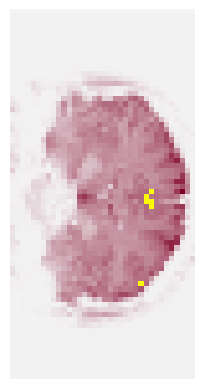

In [20]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

extent = -0.5, 35.5, 71.5, -0.5
fig = plt.figure(frameon=False)
im1 = plt.imshow(mean_haxby.get_fdata()[:,36,:],cmap=cmap,extent=extent)
im2 = plt.imshow(Z_UM.get_fdata()[:,36,:],cmap=cmapt,extent=extent)
plt.axis('off')
fig.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/realDataXZ.png', transparent=True, bbox_inches = 'tight',dpi=1000)

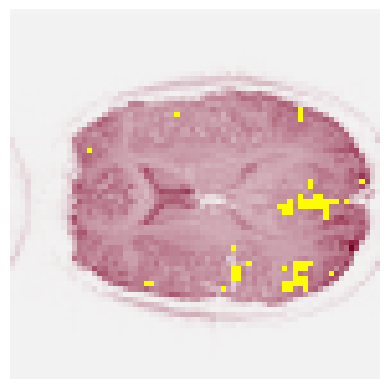

In [21]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

extent = -0.5, 35.5, 35.5, -0.5
fig = plt.figure(frameon=False)
im1 = plt.imshow(mean_haxby.get_fdata()[:,:,18],cmap=cmap,extent=extent)
im2 = plt.imshow(Z_UM.get_fdata()[:,:,18],cmap=cmapt,extent=extent)
plt.axis('off')
fig.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/realDataXY.png', transparent=True, bbox_inches = 'tight',dpi=1000)

In [34]:
sum(Z[3])/len(Z[3])

0.044064075053645395

In [33]:
sum(Z[3])/np.prod(Z_UM.get_fdata().shape)

0.009462877229080933

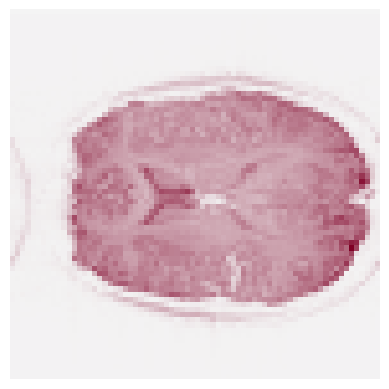

In [8]:
from nilearn.masking import unmask
import matplotlib.pyplot as plt

extent = -0.5, 35.5, 35.5, -0.5
fig = plt.figure(frameon=False)
im1 = plt.imshow(mean_haxby.get_fdata()[:,:,18],cmap=cmap,extent=extent)
#im2 = plt.imshow(Z_UM.get_fdata()[:,:,18],cmap=cmapt,extent=extent)
plt.axis('off')
fig.savefig('Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/realExample.png', transparent=True, bbox_inches = 'tight',dpi=1000)

## 3D Maps

In [88]:
act = Z_UM.get_fdata()
act.shape

(72, 72, 36)

In [87]:
arr = mean_haxby.get_fdata()
arr.shape

(72, 72, 36)

[]

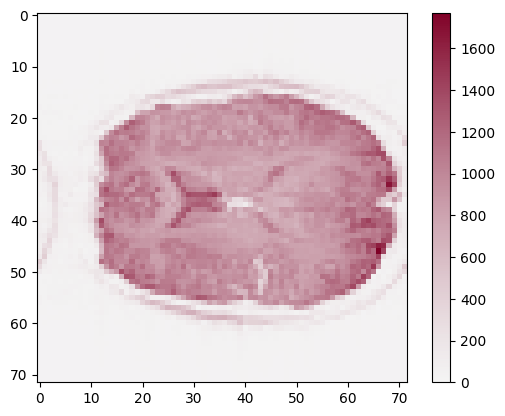

In [17]:
import matplotlib.pyplot as plt

plt.imshow(arr[:,:,18],cmap=cmap)
plt.colorbar()
plt.plot()

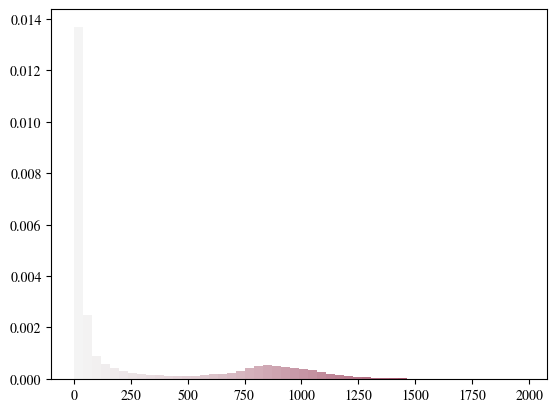

In [50]:
import numpy as np
from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cmap(c))

    plt.show()
    
show_histogram(arr)

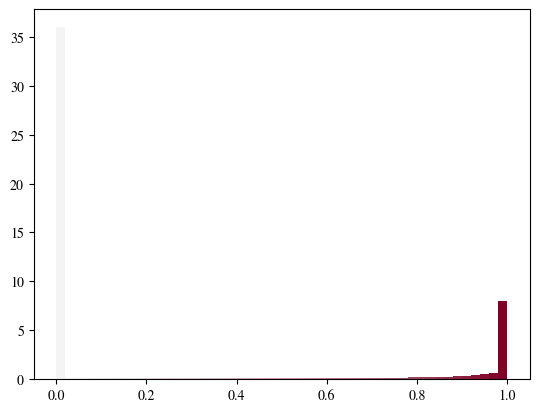

In [51]:
def scale_by(arr, fac):
    mean = np.mean(arr)
    return (arr-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(arr)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)
show_histogram(transformed)

In [85]:
#https://terbium.io/2017/12/matplotlib-3d/

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube_small(cube, fn, angle=320):
    cube = normalize(cube)
    
    facecolors = cmap(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(2.5, 2.5))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30, angle)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_zaxis().set_ticks([])
    #ax.set_xlim(right=IMG_DIM*2)
    #ax.set_ylim(top=IMG_DIM*2)
    #ax.set_zlim(top=IMG_DIM*2)
    bbox = fig.bbox_inches.from_bounds(0.4, 0.35, 1.85, 1.75)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    fig.savefig(fn, transparent=True, bbox_inches = bbox,dpi=1000)
    plt.show()

def plot_cube_large(cube, fn, angle=320):
    cube = normalize(cube)
    
    facecolors = cmap(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30, angle)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_zaxis().set_ticks([])
    #ax.set_xlim(right=IMG_DIM*2)
    #ax.set_ylim(top=IMG_DIM*2)
    #ax.set_zlim(top=IMG_DIM*2)
    bbox = fig.bbox_inches.from_bounds(1.6, 1.5, 7.3, 6.9)
    
    ax.voxels(x, y, z, filled, edgecolors='black', facecolors=facecolors, shade=False)
    fig.savefig(fn, transparent=True, bbox_inches = bbox,dpi=1000)
    plt.show()

def plot_cube_act(cube, act, fn, angle=320):
    cube = normalize(cube)
    
    facecolors = cmap(cube)

    facecolors[:,:,:,-1] = cube
    
    for i in range(facecolors.shape[0]):
        for j in range(facecolors.shape[1]):
            for k in range(facecolors.shape[2]):
                if act[i,j,k] == 0:
                    #facecolors[i,j,k] = np.array([255,255,255,0])/255
                    facecolors[i,j,k,-1] = 0
    
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30, angle)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_zaxis().set_ticks([])
    #ax.set_xlim(right=IMG_DIM*2)
    #ax.set_ylim(top=IMG_DIM*2)
    #ax.set_zlim(top=IMG_DIM*2)
    bbox = fig.bbox_inches.from_bounds(1.6, 1.5, 7.3, 6.9)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    fig.savefig(fn, transparent=True, bbox_inches = bbox,dpi=1000)
    plt.show()

def plot_cube_act_trans(cube, act, fn, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.Greys(cube)
    facecolorsact = cmap(cube)

    facecolors[:,:,:,-1] = cube
    
    for i in range(facecolors.shape[0]):
        for j in range(facecolors.shape[1]):
            for k in range(facecolors.shape[2]):
                if act[i,j,k] == 1:
                    facecolors[i,j,k] = facecolorsact[i,j,k]
                    #facecolors[i,j,k] = np.array([255,255,255,0])/255
                    #facecolors[i,j,k,-1] = 0
    
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30, angle)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_zaxis().set_ticks([])
    #ax.set_xlim(right=IMG_DIM*2)
    #ax.set_ylim(top=IMG_DIM*2)
    #ax.set_zlim(top=IMG_DIM*2)
    bbox = fig.bbox_inches.from_bounds(1.6, 1.5, 7.3, 6.9)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    fig.savefig(fn, transparent=True, bbox_inches = bbox,dpi=1000)
    plt.show()

In [54]:
cmap(pM)[:,:,:,-1].shape

(40, 40, 25)

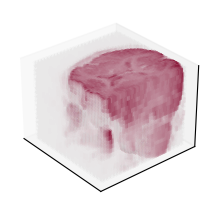

In [68]:
plot_cube_small(arr[:50,10:70,:18],'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dSmall.png')

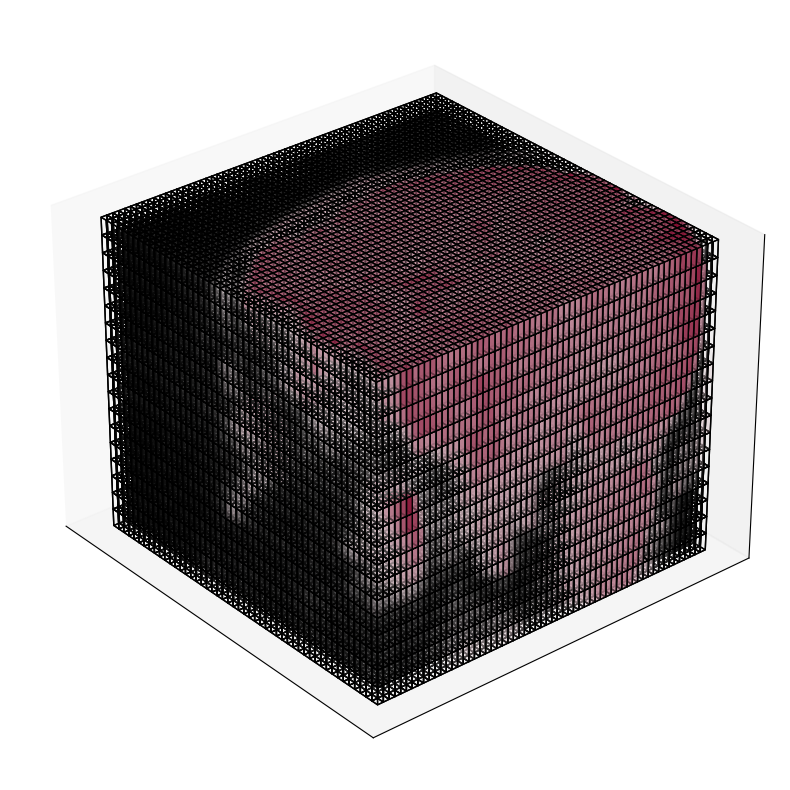

In [81]:
plot_cube_large(arr[:50,10:70,:18],'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dVoxels.png')

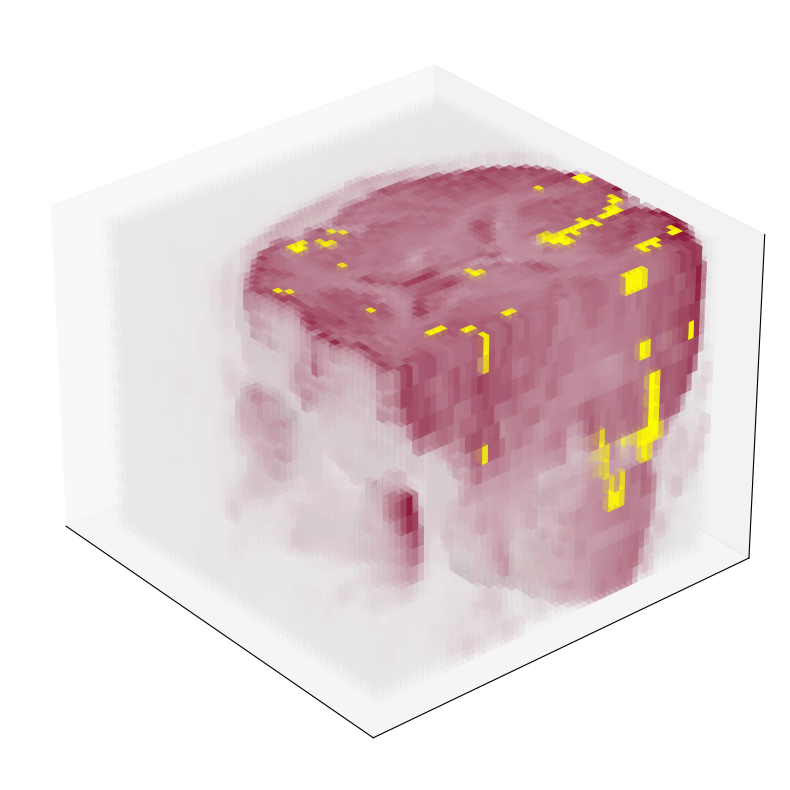

In [83]:
plot_cube_act(arr[:50,10:70,:18], act[:50,10:70,:18], 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dAct.png')

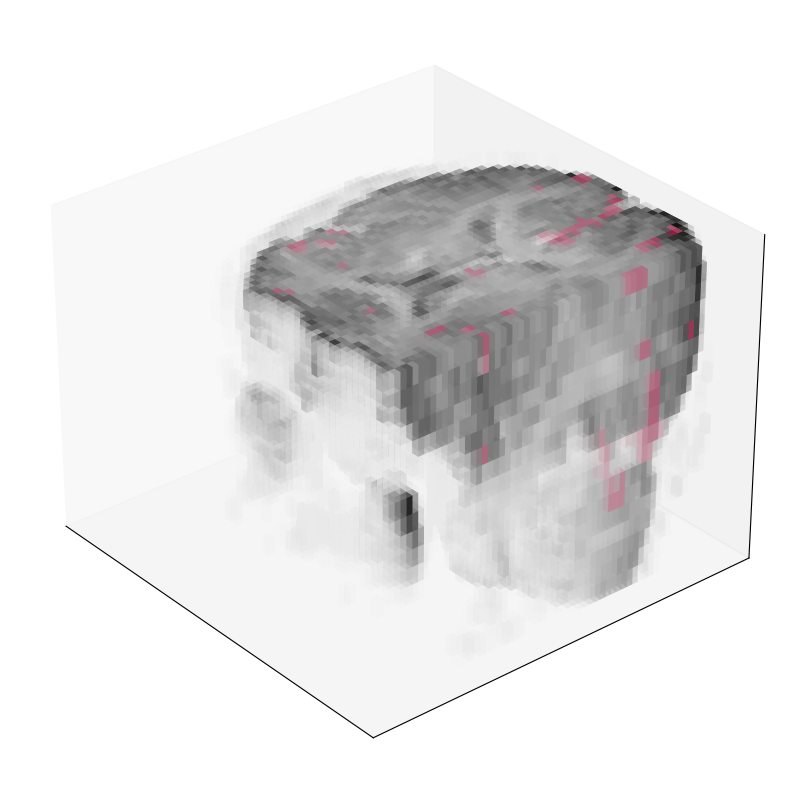

In [89]:
plot_cube_act_trans(arr[:50,10:70,:18], act[:50,10:70,:18], 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dActNuevo.png')

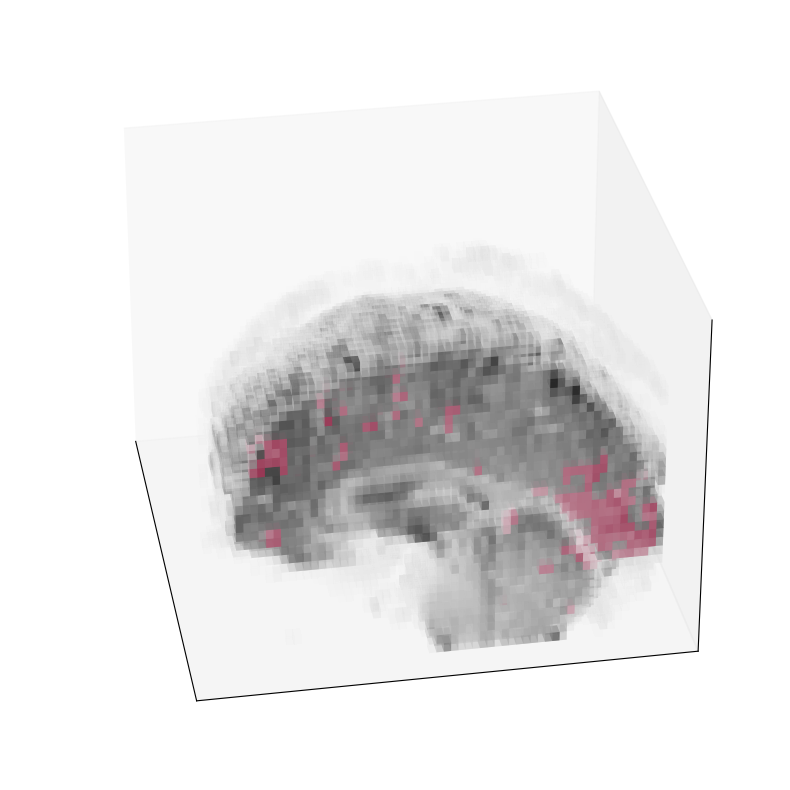

In [90]:
plot_cube_act_trans(arr[:37,10:70,:], act[:37,10:70,:], 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dAct2Nuevo.png',350)

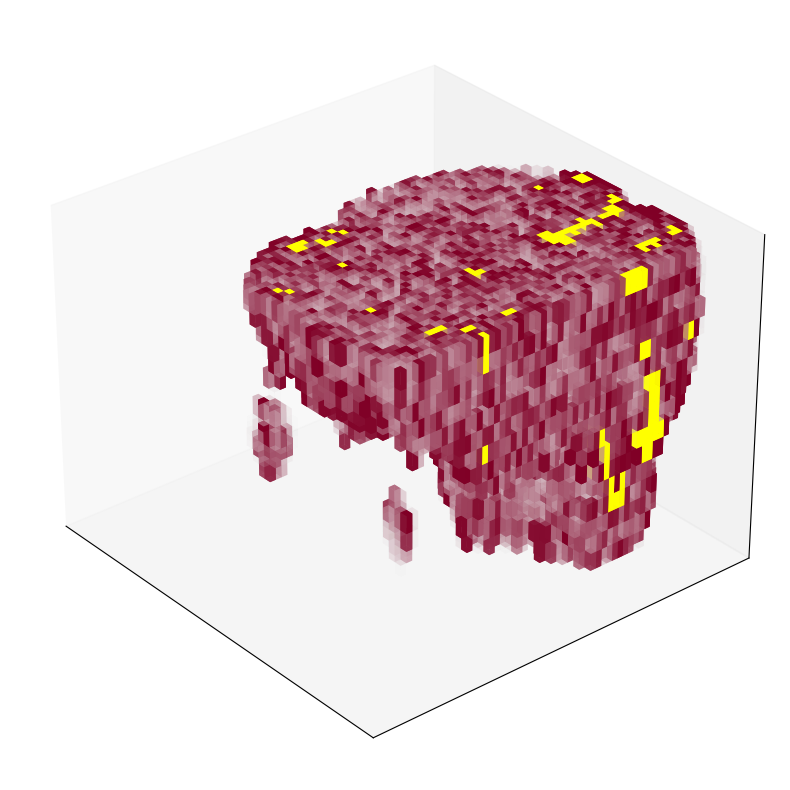

In [18]:
arr = pMap_UM.get_fdata()
act = Z_UM.get_fdata()
plot_cube_act(arr[:50,10:70,:18], act[:50,10:70,:18], 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dActPr.png')

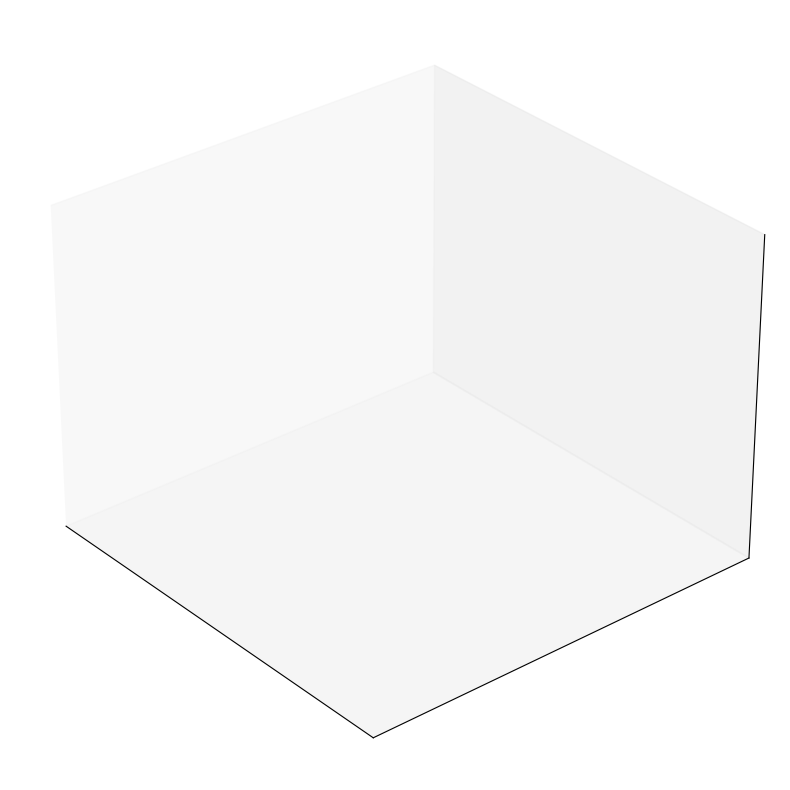

In [59]:
import numpy as np
pMaps00 = np.load('Data/Simulations/Run032724/3D/X_P0Q0R1.npy')
aMaps00 = np.load('Data/Simulations/Run032724/3D/Zeta_P0Q0R1.npy')
k = 0
pM = pMaps00[k,:].reshape(40,40,25)
aM = aMaps00[k,:].reshape(40,40,25)
plot_cube_act(pM, aM, 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dSimActPrk0.png')

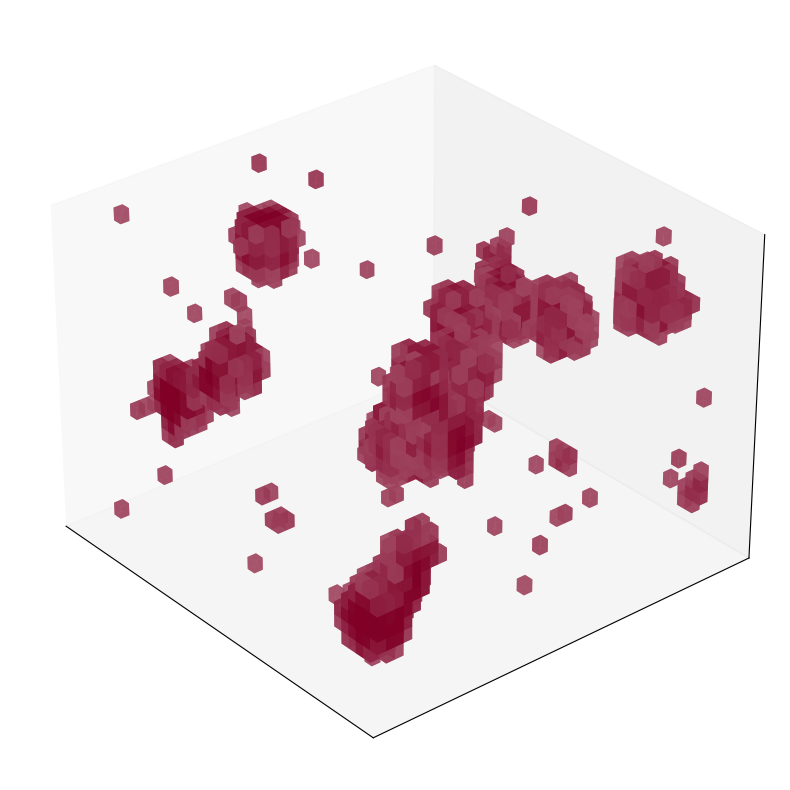

In [58]:
k = 1
pM = pMaps00[k,:].reshape(40,40,25)
aM = aMaps00[k,:].reshape(40,40,25)
plot_cube_act(pM, aM, 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dSimActPrk1.png')

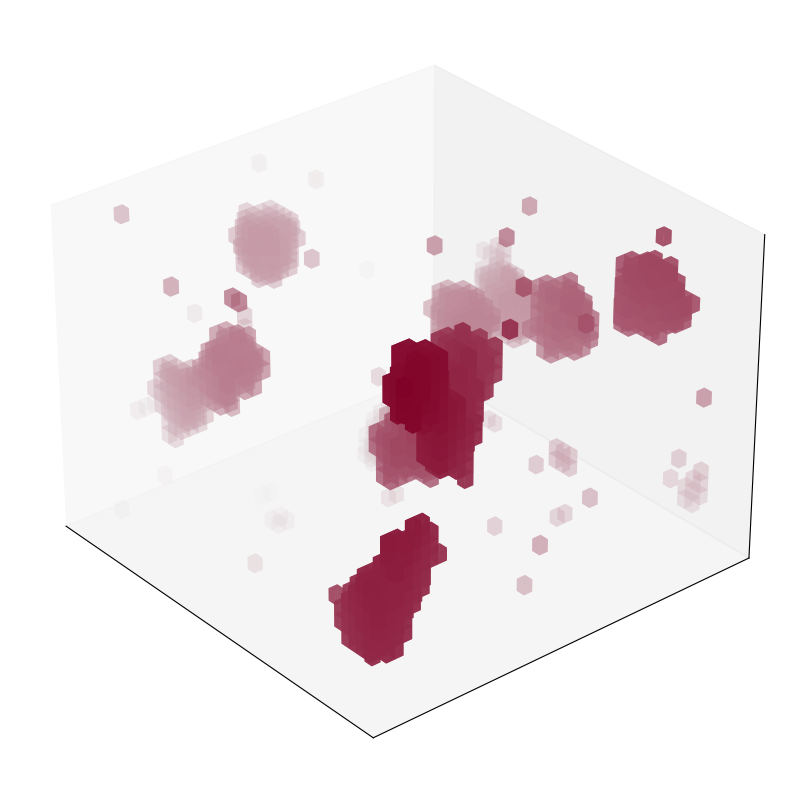

In [57]:
k = 2
pM = pMaps00[k,:].reshape(40,40,25)
aM = aMaps00[k,:].reshape(40,40,25)
plot_cube_act(pM, aM, 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dSimActPrk2.png')

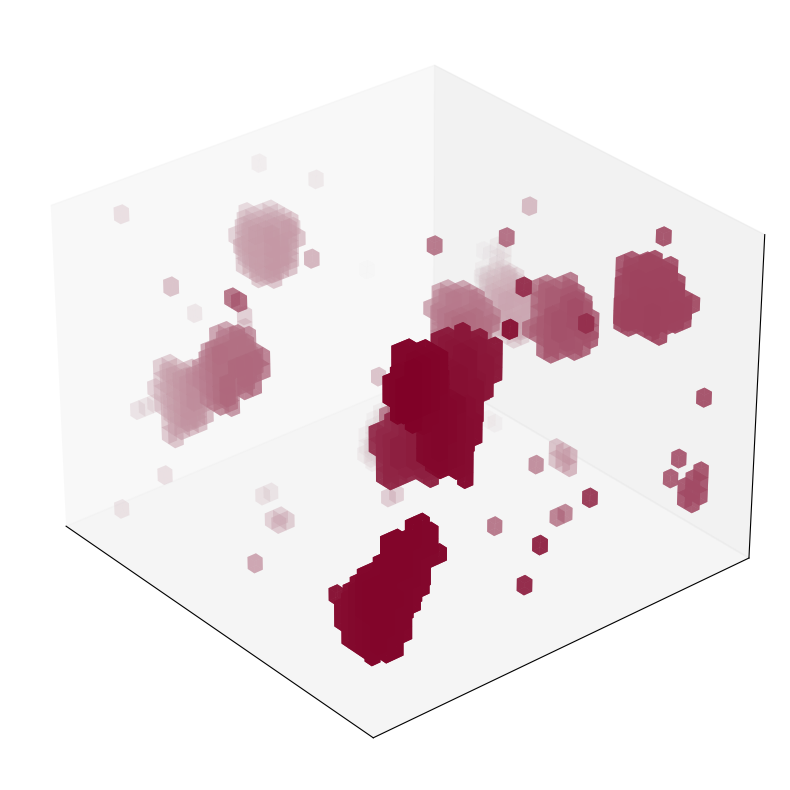

In [56]:
k = 3
pM = pMaps00[k,:].reshape(40,40,25)
aM = aMaps00[k,:].reshape(40,40,25)
plot_cube_act(pM, aM, 'Thesis_MS_ScientificComputing_FlorezCoronel_JuanE/images/plot3dSimActPrk3.png')

In [ ]:
filled = np.array([
    [[1,0,0],
     [1,0,0],
     [1,1,1]],
    [[0,0,0],
     [0,0,0],
     [1,0,0]],
    [[0,0,0],
     [0,0,0],
     [1,0,0]]
])

filled = explode(filled)

colors = np.array([[['#7f012650']*3]*3]*3)
colors[0,2,0] = 'black'

colors = explode(colors)

x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

ax = make_ax()
ax.voxels(x,y,z, filled, edgecolors='gray', facecolors=colors, shade=False)
plt.show()